# 필수 라이브러리 선언

In [1]:
from dotenv import load_dotenv
from textwrap import dedent     # tap(들여쓰기)에 상관없이 쓸 수 있게.
from pprint import pprint
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import TypedDict
import os
load_dotenv()

True

# State 선언 및 타입 지정

In [2]:
class EmotionState(TypedDict):
    user_input: str         # 유저 입력값
    sentiment: str          # 감정 분기 단어
    final_response: str     # 최종 결과출력

# 랭그래프 필요 라이브러리 선언

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

# 유저 입력값 노드

In [4]:
def get_user_input(state: EmotionState) -> EmotionState:
    user_input = input('오늘의 감정은 어떠신가요?')
    return {"user_input":user_input}

# 분기 노드 추가

In [5]:
def analyze_sentiment(state: EmotionState) -> EmotionState:
    sentiment_template = """
    사용자의 입력에 따라서 그사람의 감정의 상태를 판단하세요.
    
    사용자의 입력: {user_input}
    
    사용자의 입력이 긍정적이면 "positive"를 부정적이면 "negative"으로 답변하고, 중립적인 입력에 대해서는"neutral"로 답변하세요.
    
    답변:
    """
    
    sentiment_prompt = ChatPromptTemplate.from_template(sentiment_template)
    sentiment_chain = sentiment_prompt | llm | StrOutputParser()
    
    result = sentiment_chain.invoke({"user_input":state['user_input']})
    sentiment = result.strip().lower()
    return {"sentiment":sentiment}

# 긍정 답변 (generate_congrats_response)

In [6]:
def generate_congrats_response(state: EmotionState) -> EmotionState:
    response_template = """
    사용자 입력: {user_input}
    사용자 감정 결과: {sentiment}
    
    위 정보를 바탕으로 사용자의 감정에 공감할 수 있을만한 답변을 생성하세요.
    
    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_response = response_chain.invoke({"user_input":state['user_input'],"sentiment":state['sentiment']})
    print(f"""
\n 현재 감정: {state['sentiment']}
\n 감정 분석 결과 답변: {final_response}          
          """)
    return {"final_response":final_response}
    

# 부정 답변 (generate_encouragement_response)

In [7]:
def generate_encouragement_response(state: EmotionState) -> EmotionState:
    response_template = """
    사용자 입력: {user_input}
    사용자 감정 결과: {sentiment}
    
    위 정보를 바탕으로 사용자의 감정에 공감할 수 있을만한 답변을 생성하세요.
    
    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_response = response_chain.invoke({"user_input":state['user_input'],"sentiment":state['sentiment']})
    print(f"""
\n 현재 감정: {state['sentiment']}
\n 감정 분석 결과 답변: {final_response}          
          """)
    return {"final_response":final_response}
    

# 중립 답변 (generate_neutral_response)

In [ ]:
def generate_neutral_response(state: EmotionState) -> EmotionState:
    response_template = """
    사용자 입력: {user_input}
    사용자 감정 결과: {sentiment}
    
    위 정보를 바탕으로 사용자의 감정에 공감할 수 있을만한 답변을 생성하세요.
    
    감정이 중립적이라면 그거에 대한 답변을 생성하세요.
    
    답변:
    """
    response_prompt = ChatPromptTemplate.from_template(response_template)
    response_chain = response_prompt | llm | StrOutputParser()
    
    final_response = response_chain.invoke({"user_input":state['user_input'],"sentiment":state['sentiment']})
    print(f"""
\n 현재 감정: {state['sentiment']}
\n 감정 분석 결과 답변: {final_response}          
          """)
    return {"final_response":final_response}

# 분기구문 작성 (답변에 따른 분기 작성)

In [9]:
from typing import Literal

def check_by_sentiment(state: EmotionState) -> Literal["generate_congrats_response", "generate_encouragement_response", "generate_neutral_response"]:
    if state['sentiment'] == 'positive': return "generate_congrats_response"
    elif state['sentiment'] == 'negative': return "generate_encouragement_response"
    else: return "generate_neutral_response"

# LangGraph 작성

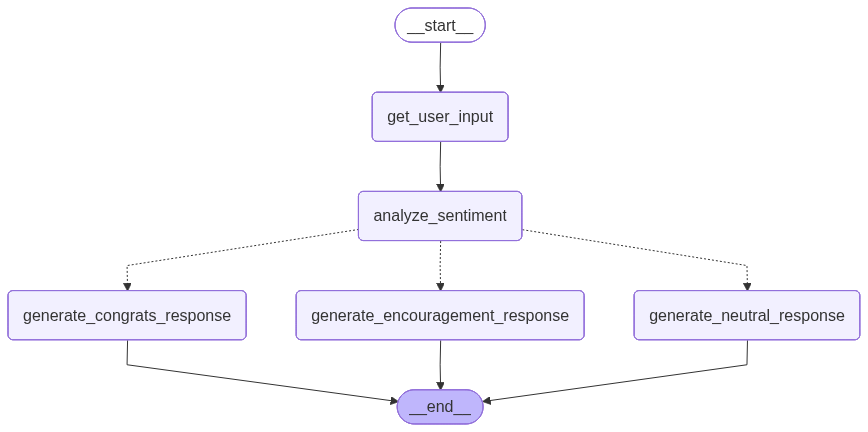

In [ ]:
# 1. 빌더 생성
builder = StateGraph(EmotionState)
# 2. 노드 추가 (이 때는 순서 상관없음)
builder.add_node("get_user_input",get_user_input)
builder.add_node("analyze_sentiment", analyze_sentiment)
builder.add_node("generate_congrats_response", generate_congrats_response)
builder.add_node("generate_encouragement_response", generate_encouragement_response)
builder.add_node("generate_neutral_response",generate_neutral_response)
# 3. 엣지로 순서도 작성 (순서가 중요함.)
builder.add_edge(START, "get_user_input")
builder.add_edge("get_user_input", "analyze_sentiment")
# 3-1. 분기문 추가할때 add_conditional_edges 사용함.
builder.add_conditional_edges(
    "analyze_sentiment",                                            # 감정 반환 함수 로드
    check_by_sentiment,                                             # 감정에 따른 분기 리터럴 값 반환하는 함수 로드
    {
        "generate_congrats_response": "generate_congrats_response",              # 리터럴에 따른 분기 value 지정
        "generate_encouragement_response": "generate_encouragement_response",    # 리터럴에 따른 분기 value 지정
        "generate_neutral_response":"generate_neutral_response"                  # 리터럴에 따른 분기 value 지정
    }
)
# 3-2. 분기 별 END 엣지 추가.
builder.add_edge("generate_congrats_response", END)
builder.add_edge("generate_encouragement_response", END)
builder.add_edge("generate_neutral_response", END)
# 4. 그래프 추가
graph = builder.compile()
# 4-1. node 플로우 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

# 실행하기 (긍정)

In [ ]:
while True:
    init_state = {"user_input":''}
    graph.invoke(init_state)
    continue_chat = input('다른 질문이 있으신가요? (y/n)').lower()
    if continue_chat != 'y':
        print('종료 합니다.')
        break



 현재 감정: positive

 감정 분석 결과 답변: 와, 정말 축하해요! 승진은 정말 큰 성과죠. 그동안의 노력과 열정이 인정받은 것 같아 기쁘네요. 어떤 기분인지 정말 잘 알 것 같아요!          
          
종료 합니다.


# 실행하기 (부정)

In [ ]:
while True:
    init_state = {"user_input":''}
    graph.invoke(init_state)
    continue_chat = input('다른 질문이 있으신가요? (y/n)').lower()
    if continue_chat != 'y':
        print('종료 합니다.')
        break



 현재 감정: negative

 감정 분석 결과 답변: 슬픈 기분이 드는 날에 파마를 하셨군요. 때때로 변화가 필요할 때가 있죠. 새로운 스타일이 기분을 조금이나마 나아지게 해주길 바래요. 힘든 시간이 지나가길 응원할게요. 언제든지 이야기할 곳이 필요하면 여기 있어요!          
          
종료 합니다.


# 실행하기 (neutral)

In [ ]:
while True:
    init_state = {"user_input":''}
    graph.invoke(init_state)
    continue_chat = input('다른 질문이 있으신가요? (y/n)').lower()
    if continue_chat != 'y':
        print('종료 합니다.')
        break



 현재 감정: neutral

 감정 분석 결과 답변: 그런 기분이 드는 것도 자연스러운 일이에요. 때로는 특별한 이유 없이 그냥 평온한 상태가 될 때가 있죠. 이런 중립적인 감정도 자신을 돌아보는 좋은 기회가 될 수 있어요. 혹시 오늘 어떤 활동을 해보셨나요?          
          
종료 합니다.
